# Metadata

```yaml
Course:    DS 5001 
Module:    09 Lab
Topic:     Using GloVe
Author:    R.C. Alvarado
Date:      28 March 2023 (revised)
```

**Purpose:** We use some pretrained word vectors from [the developers of GloVe](https://nlp.stanford.edu/projects/glove/).

# Set Up

In [1]:
data_in = '../data/glove'
db_file = f'{data_in}/glove2.db'

In [2]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity

# Import GloVe data

In [137]:
glove = pd.read_csv("../data/glove/glove.6B/glove.6B.50d.txt", sep="\s", header=None)

/var/folders/14/rnyfspnx2q131jp_752t9fc80000gn/T/ipykernel_30903/3162180923.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  glove = pd.read_csv("../data/glove/glove.6B/glove.6B.50d.txt", sep="\s", header=None)


In [138]:
glove = glove.set_index(0)

In [139]:
glove.index.name = 'term_str'

In [140]:
glove.index.has_duplicates

True

In [141]:
glove.index.value_counts()

the           1
fedden        1
chlorinate    1
kalapana      1
40.64         1
             ..
olatunde      1
alemao        1
zanca         1
natsteel      1
sandberger    1
Name: term_str, Length: 399997, dtype: int64

In [143]:
glove.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
term_str,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.12170,0.34527,-0.044457,-0.49688,-0.17862,-0.00066,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.44251,0.187850,0.002785,-0.184110,-0.115140,-0.78581
",",0.013441,0.236820,-0.16899,0.40951,0.63812,0.477090,-0.42852,-0.55641,-0.36400,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.22786,0.360340,-0.378180,-0.566570,0.044691,0.30392
.,0.151640,0.301770,-0.16763,0.17684,0.31719,0.339730,-0.43478,-0.31086,-0.44999,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.13931,0.223140,-0.080803,-0.356520,0.016413,0.10216
of,0.708530,0.570880,-0.47160,0.18048,0.54449,0.726030,0.18157,-0.52393,0.10381,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.680470,-0.039263,0.30186,-0.17792,0.42962,0.032246,-0.41376,0.13228,-0.29847,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044


# Remove non-words

There are a lot of useless tokens in the vocabulary. These may be good for generating the features, but we don't need them in our queries.

In [176]:
# glove = glove.reset_index()
# glove = glove[glove.term_str.str.match(r'^[a-z]+$')]
# glove = glove.set_index('term_str')
# glove.shape

# Define some semantic functions

In [182]:
def get_word_vector(term_str):
    """Get a numpy array from the glove matrix and shape for input into cosine function"""
    wv = glove.loc[term_str].values.reshape(-1, 1).T
    return wv

def get_sims(term_str, n=10):
    """Get the top n words for a given word based on cosine similarity"""
    wv = get_word_vector(term_str)
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(n)

def get_nearest_vector(wv):
    """Get the nearest word vector to a given word vector"""
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(2).iloc[1]

def get_analogy(a, b, c):
    """Infer missing analogical term"""
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = get_word_vector(c)
        D = np.add(np.subtract(B, A), C)
        X = get_nearest_vector(D)
        return X.name
    except ValueError as e:
        print(e)
        return None

# Test similarity function

In [183]:
get_sims('queen')

,score
term_str,
queen,1.000000
princess,0.851517
lady,0.805061
elizabeth,0.787304
king,0.783904
prince,0.782186
coronation,0.769278
consort,0.762610
royal,0.744286


In [184]:
get_sims('king')

,score
term_str,
king,1.000000
prince,0.823618
queen,0.783904
ii,0.774623
emperor,0.773625
son,0.766719
uncle,0.762715
kingdom,0.754216
throne,0.753991


In [185]:
get_sims('milk')

,score
term_str,
milk,1.000000
sugar,0.821547
drink,0.815409
soda,0.808969
peanut,0.806213
juice,0.803572
dairy,0.792757
meat,0.791714
butter,0.789752


In [186]:
get_sims('beer')

,score
term_str,
beer,1.000000
drink,0.849374
drinks,0.833444
coffee,0.804246
vodka,0.797950
beers,0.793020
champagne,0.776821
brewed,0.772739
soda,0.768293


# Test analogy functions

In [187]:
get_analogy('dog','male','cat')

'female'

In [188]:
get_analogy('male','doctor','female')

'nurse'

In [189]:
get_analogy('king', 'queen', 'male')

'female'

In [152]:
get_analogy('queen','female','king')

'male'

In [153]:
get_analogy('female','princess','male')

'duchess'

In [154]:
get_analogy('right','male','left')

'male'

In [204]:
get_analogy('male', 'female', 'right')

'put'

In [155]:
get_analogy('right','left','male')

'male'

In [156]:
get_analogy('left','right','black')

'white'

In [157]:
get_analogy('left','right','white')

'black'

In [158]:
get_analogy('sun','moon','male')

'male'

In [159]:
get_analogy('day','sun','night')

'sky'

# Experiment

Demonstrate how to project embeddings onto documents

In [161]:
LIB = pd.read_csv("../data/output/austen-melville-LIB_FIXED.csv").set_index('book_id')

In [162]:
CORPUS = pd.read_csv("../data/output/austen-melville-CORPUS.csv")\
    .merge(glove, on="term_str")\
    .set_index(['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num'])\
    .iloc[:, 4:]

In [163]:
CORPUS

1         2         3   \
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0          0.15408  0.759330 -0.471300   
                4        0        12         0.15408  0.759330 -0.471300   
                5        0        87         0.15408  0.759330 -0.471300   
                6        0        11         0.15408  0.759330 -0.471300   
                7        0        8          0.15408  0.759330 -0.471300   
...                                              ...       ...       ...   
34970   114     13       0        10        -0.10870 -0.780970 -0.575230   
                         2        8          0.53049 -0.636570 -0.533140   
                17       0        28         0.37567 -1.520800 -0.039892   
                18       3        11         0.86343  0.004638 -0.851650   
                                  16         0.86343  0.004638 -0.851650   

                                                   4        5         6   \
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0         -0.684190  0.66657  0.020698   
                4        0        12        -0.684190  0.66657  0.020698   
                5        0        87        -0.684190  0.66657  0.020698   
                6        0        11        -0.684190  0.66657  0.020698   
                7        0        8         -0.684190  0.66657  0.020698   
...                                               ...      ...       ...   
34970   114     13       0        10         0.006008 -0.27756 -0.305890   
                         2        8         -0.375420  0.28821  1.237400   
                17       0        28        -0.432260 -0.20000 -0.151140   
                18       3        11        -0.316740 -0.35847 -0.539820   
                                  16        -0.316740 -0.35847 -0.539820   

                                                  7        8         9   \
book_id chap_id para_num sent_num token_num                               
105     1       1        0        0         -0.82138  0.32687 -0.804420   
                4        0        12        -0.82138  0.32687 -0.804420   
                5        0        87        -0.82138  0.32687 -0.804420   
                6        0        11        -0.82138  0.32687 -0.804420   
                7        0        8         -0.82138  0.32687 -0.804420   
...                                              ...      ...       ...   
34970   114     13       0        10         0.47459  0.17865 -0.006944   
                         2        8         -0.47467 -1.20370  0.582090   
                17       0        28         0.35699  0.75466 -0.088619   
                18       3        11         0.73907  0.66941  0.052928   
                                  16         0.73907  0.66941  0.052928   

                                                  10  ...       41        42  \
book_id chap_id para_num sent_num token_num           ...                      
105     1       1        0        0         -1.34970  ...  0.84756  1.014000   
                4        0        12        -1.34970  ...  0.84756  1.014000   
                5        0        87        -1.34970  ...  0.84756  1.014000   
                6        0        11        -1.34970  ...  0.84756  1.014000   
                7        0        8         -1.34970  ...  0.84756  1.014000   
...                                              ...  ...      ...       ...   
34970   114     13       0        10         1.51110  ... -0.21233  0.273010   
                         2        8         -0.55149  ...  0.32885  0.572850   
                17       0        28         0.15833  ... -0.34531 -0.032317   
                18       3        11         0.24664  ... -1.24120 -0.210910   
                                  16         0.24664  ... -1.24120 -0.210910   

                                                  43   

In [164]:
BOOKS = CORPUS.groupby('book_id').mean()

In [165]:
BOOKS

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.323545,0.130375,-0.138879,-0.245284,0.429670,0.207292,-0.423724,0.076339,-0.232307,-0.060521,...,-0.157819,0.088310,-0.029153,0.150974,-0.054749,0.006546,-0.230543,-0.195147,-0.052740,-0.030568
121,0.324524,0.146049,-0.132952,-0.247241,0.442528,0.181426,-0.386801,0.069392,-0.215634,-0.025070,...,-0.150170,0.074479,-0.036294,0.174485,-0.046944,0.002776,-0.192248,-0.197593,-0.055893,-0.032289
141,0.316918,0.137231,-0.128935,-0.254841,0.430273,0.203088,-0.401161,0.075366,-0.222743,-0.023045,...,-0.153490,0.084964,-0.035502,0.159466,-0.050061,-0.000043,-0.213604,-0.182040,-0.052641,-0.009841
158,0.316814,0.132361,-0.130478,-0.248837,0.447975,0.186106,-0.394266,0.076542,-0.231446,-0.010712,...,-0.154607,0.080837,-0.038184,0.178259,-0.035039,0.007859,-0.213723,-0.164035,-0.042073,0.039832
161,0.312367,0.141866,-0.126897,-0.262345,0.442250,0.207670,-0.389031,0.088340,-0.214907,-0.020283,...,-0.149661,0.076487,-0.036526,0.164505,-0.045916,-0.011587,-0.212383,-0.178812,-0.045700,-0.014388
946,0.318215,0.165525,-0.126256,-0.265697,0.451028,0.175482,-0.333226,0.116844,-0.228130,0.007189,...,-0.132155,0.062069,-0.036837,0.177433,-0.036822,0.001203,-0.206038,-0.179400,-0.037422,0.063258
1212,0.311875,0.162135,-0.131199,-0.258385,0.446084,0.172494,-0.361823,0.074600,-0.227629,-0.031131,...,-0.136514,0.059259,-0.042337,0.166035,-0.047415,0.021623,-0.208847,-0.205562,-0.044726,-0.004992
1342,0.317907,0.138468,-0.135627,-0.252612,0.449312,0.199988,-0.390621,0.096263,-0.232130,-0.034875,...,-0.145135,0.083121,-0.051874,0.154525,-0.044942,-0.004497,-0.220922,-0.185624,-0.043178,0.000160
1900,0.335349,0.109812,-0.138289,-0.201990,0.364711,0.169110,-0.349099,-0.012520,-0.167956,-0.082440,...,-0.181710,0.028737,-0.022690,0.163153,-0.061622,0.018126,-0.138243,-0.169704,-0.082815,-0.235801


<AxesSubplot: ylabel='book_id'>

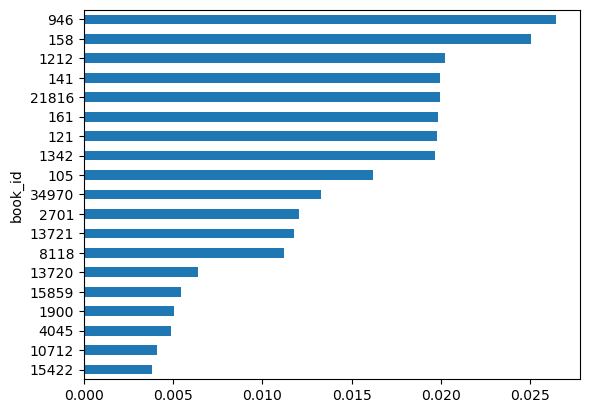

In [198]:
BOOKS.mean(1).sort_values().plot.barh()

In [199]:
import sys
sys.path.append("../lib")

In [202]:
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

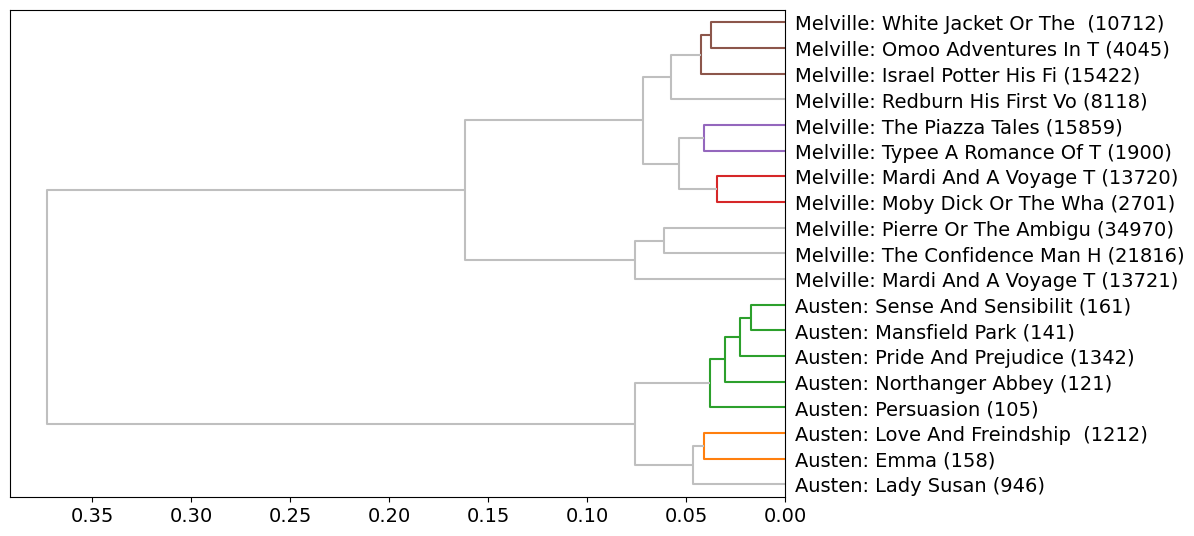

In [203]:
HAC(BOOKS, labels=BOOKS.join(LIB, how='left').label.to_list()).plot()